In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, splitext

In [8]:
from os import listdir


input_dir = '../dataset/test'
output_dir = '../dataset/output'
gt_dir = '../dataset/groundtruth'
numImages = 80

# input_dir = '../add_dataset/test'
# output_dir = '../add_dataset/output'
# gt_dir = '../add_dataset/groundtruth'
# numImages = 20

eps = 0.00000001

onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
files = onlyfiles[0:numImages]

In [9]:
def remove_circle (img) :

        greyScale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(greyScale, 1, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)

        # Create a mask for the circular region
        mask = np.zeros_like(greyScale)
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)

        # Invert the mask to remove the circular boundary
        inverted_mask = cv2.bitwise_not(mask)

        kernel = np.ones((3, 3), np.uint8)
        inverted_mask = cv2.dilate(inverted_mask, kernel,iterations=1)

        return inverted_mask

In [10]:
def segmentImage(img, c_value=5):

    green_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]

    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(green_channel)

    # Apply median blur to reduce noise
    filtered_img = cv2.GaussianBlur(enhanced_img,(5,5),1) 

    outImg = cv2.adaptiveThreshold(
        filtered_img,
        maxValue=1,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=c_value,
    )        

    # Post-processing to remove small regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(outImg, connectivity=8)
    min_size = 45
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            outImg[labels == i] = 0

    # Remove the circular region
    remove_circle_img = remove_circle(img)

    outImg = cv2.subtract(outImg, remove_circle_img)

    # END OF YOUR CODE
    #########################################################################
    return outImg

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def calculate_result(c_v=5):
    error = np.zeros((numImages, 1))
    precision = np.zeros((numImages, 1))
    recall = np.zeros((numImages, 1))
    iou = np.zeros((numImages, 1))

    precision_below_40 = []
    precision_40_50 = []
    precision_50_60 = []
    precision_60_70 = []
    precision_70_80 = []
    precision_80_90 = []
    precision_90_100 = []  # List to store indices of images in different precision ranges

    for i, name in enumerate(files):
        inputImg = cv2.imread(input_dir + '/' + name)
        outputImg = segmentImage(inputImg, c_v).astype('float32')
        imgName = splitext(name)
        gt = cv2.imread(gt_dir + '/' + imgName[0] + '.png', 0)
        gt = np.round(gt.astype('float32') / gt.max())

        precision[i] = np.round(sum(sum(gt * outputImg)) / (sum(sum(outputImg)) + eps), 4)
        recall[i] = sum(sum(gt * outputImg)) / sum(sum(gt))
        error[i] = 1 - ((2 * precision[i] * recall[i]) / (precision[i] + recall[i] + eps))
        iou[i] = sum(sum(gt * outputImg)) / sum(sum(np.clip(gt + outputImg, 0, 1)))

    # Classify precision values into intervals
    for i, p in enumerate(precision):
        p_value = p[0]  # Extracting the value from the precision array (which is a 2D array)
        
        if p_value <= 0.40:
            precision_below_40.append(i + 1)
        elif 0.40 < p_value <= 0.50:
            precision_40_50.append(i + 1)
        elif 0.50 < p_value <= 0.60:
            precision_50_60.append(i + 1)
        elif 0.60 < p_value <= 0.70:
            precision_60_70.append(i + 1)
        elif 0.70 < p_value <= 0.80:
            precision_70_80.append(i + 1)
        elif 0.80 < p_value <= 0.90:
            precision_80_90.append(i + 1)
        elif 0.90 < p_value <= 1.00:
            precision_90_100.append(i + 1)

    # Create bins for precision values
    precision_bins = np.arange(0, 1.1, 0.1)  # Bins from 0 to 1 in steps of 0.1 (0-0.1, 0.1-0.2, ..., 0.9-1.0)
    precision_counts, _ = np.histogram(precision, bins=precision_bins)

    # Create a table using pandas to show the precision range and the number of images in each range
    precision_ranges = [f'{int(b*100)}-{int((b+0.1)*100)-1}' for b in precision_bins[:-1]]
    precision_df = pd.DataFrame({
        'Precision Range (%)': precision_ranges,
        'Number of Images': precision_counts
    })

    # Add a row for the total count
    precision_df.loc[len(precision_df)] = ['Total', numImages]

    # Print the table
    print(precision_df)

    # Plot bar chart
    plt.bar(precision_ranges, precision_counts, width=0.8)
    plt.xlabel('Precision Range (%)')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Precision Values')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Make sure everything fits in the plot
    plt.show()

    # Return the precision lists
    return precision_below_40, precision_40_50, precision_50_60, precision_60_70, precision_70_80, precision_80_90, precision_90_100


   Precision Range (%)  Number of Images
0                  0-9                 0
1                10-19                 0
2                20-29                 0
3                30-39                 0
4                40-49                 2
5                50-59                 7
6                60-69                18
7                70-79                26
8                80-89                18
9                90-99                 9
10               Total                80


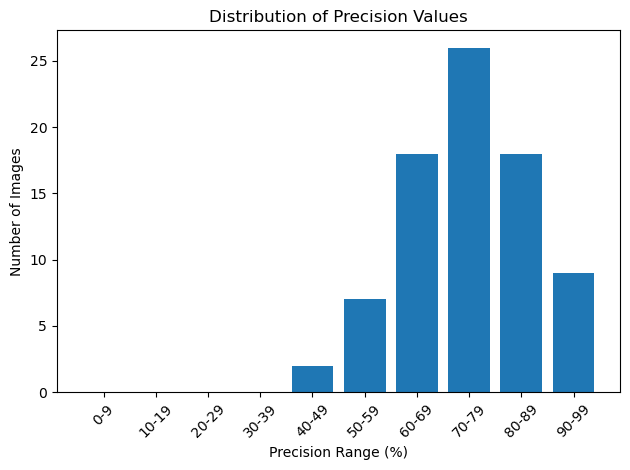

precision_below_40: []
precision_40_50: [7, 46]
precision_50_60: [1, 10, 22, 40, 43, 55, 67]
precision_60_70: [2, 4, 13, 16, 19, 23, 29, 34, 35, 38, 41, 47, 48, 49, 50, 66, 69, 72]
precision_70_80: [5, 8, 11, 12, 14, 17, 20, 25, 26, 28, 31, 32, 37, 42, 44, 51, 52, 54, 70, 71, 73, 74, 75, 76, 79, 80]
precision_80_90: [3, 6, 9, 15, 18, 21, 24, 27, 30, 33, 36, 39, 45, 53, 56, 57, 62, 77]
precision_90_100: [58, 59, 60, 61, 63, 64, 65, 68, 78]


In [12]:
precision_below_40, precision_40_50, precision_50_60, precision_60_70, precision_70_80, precision_80_90, precision_90_100 = calculate_result()

print(f"precision_below_40: {precision_below_40}")
print(f"precision_40_50: {precision_40_50}")
print(f"precision_50_60: {precision_50_60}")
print(f"precision_60_70: {precision_60_70}")
print(f"precision_70_80: {precision_70_80}")
print(f"precision_80_90: {precision_80_90}")
print(f"precision_90_100: {precision_90_100}")
